In [1]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

In [2]:
#Problems 1-2
class NMFRecommender:

    def __init__(self,random_state=15,rank=3,maxiter=200,tol=1e-3):
        """The parameter values for the algorithm"""
        self.random_state = random_state #the seed
        self.k = rank #dimension
        self.maxiter = maxiter #set maxiters baby
        self.tol = tol
    
    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices,"""
        np.random.seed(self.random_state) #set the seed
        W = np.random.random((m,self.k))
        H = np.random.random((self.k,n)) #dimensions
        return H,W
      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""
        m,n = V.shape
        H,W = self.initialize_matrices(m,n) #use above method to get H,W
        
        for i in range(self.maxiter): #update matrices iteratively
            
            w = cp.Variable((m,self.k),nonneg=True)
            #print(V,w,H)
            obj = cp.Minimize(cp.norm(V-w@H,"fro")) #frobenius norm
            prob = cp.Problem(obj) #set up the objective
            prob.solve() #solve it
            W = w.value
            if np.linalg.norm(V-W@H,ord="fro") < self.tol:
                break

            h = cp.Variable((self.k,n),nonneg=True) #now use W that we got from the above code block
            obj = cp.Minimize(cp.norm(V-W@h,"fro"))
            prob = cp.Problem(obj)
            prob.solve()
            H = h.value
            if np.linalg.norm(V-W@H,ord="fro") < self.tol:
                break
        
        self.W = W
        self.H = H


    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""
        V_opt = self.W@self.H #use optimal W,H to reconstruct V #reconstruction
        return V_opt


In [3]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )
    #you're hired!
    recs = NMFRecommender(random_state=15, rank=2, maxiter=200,tol=1e-3)
    recs.fit(V) #runs our iterative process 
    V_new = recs.reconstruct()
    

    return recs.W, recs.H, sum(recs.H[1]>recs.H[0])

In [4]:
prob3()

(array([[4.32480191e-01, 1.55954416e+00],
        [7.28906415e-01, 2.67373283e+00],
        [2.59466489e-01, 1.23238130e+00],
        [2.77259088e+00, 7.64369539e-08],
        [2.08546906e-09, 3.68889128e-01]]),
 array([[4.28503903e-08, 7.25973906e-01, 1.07543057e+00, 1.44598707e+00,
         3.52852850e-01, 3.65398494e-01],
        [5.85611950e-01, 7.72213331e-01, 6.59496409e-02, 5.89472429e-09,
         8.03616848e-01, 7.67499335e-01]]),
 4)

In [5]:

#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


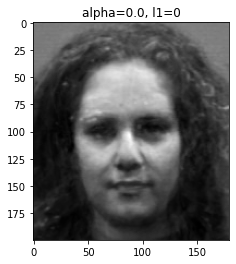

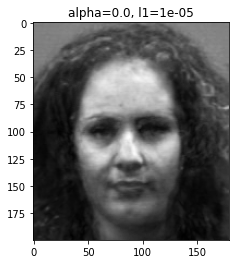

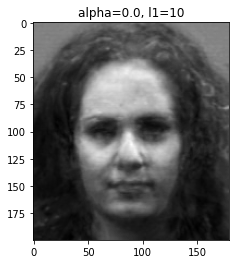

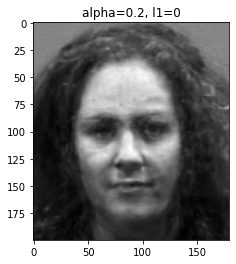

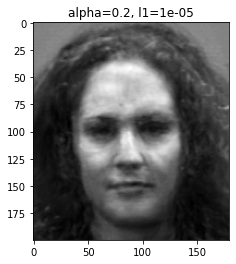

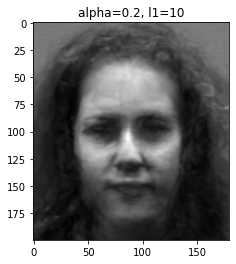

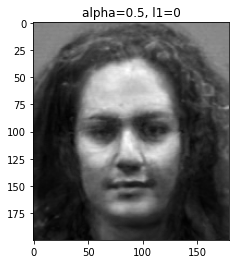

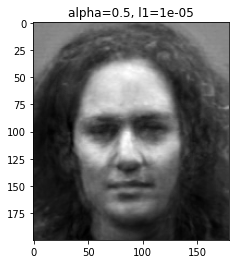

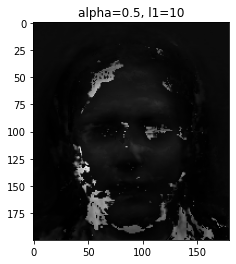

In [6]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    faces = get_faces(path="./faces94")
    n_comps = 75
    alphas = [0.0,0.2,0.5] #different alphas to try
    l1_ratios = [0,10**-5,10] #different l1_ratios
    for alph in alphas: #loop through it
        for l1_rat in l1_ratios:
            model = NMF(n_components=n_comps,alpha_H=alph,l1_ratio=l1_rat) #instantiate NMF 
            W = model.fit_transform(faces) #get W
            H = model.components_ #now get H
            reconned = (W@H)[:,2] #3rd face and 3rd face only baby
            show(reconned)
            plt.title("alpha="+str(alph)+", l1="+str(l1_rat)) #goated string formatting
            plt.show()
    
prob4()

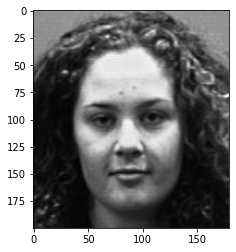

In [7]:
faces = get_faces(path="./faces94")
show(faces[:,2])
plt.show()

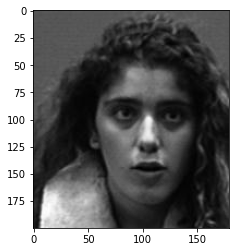

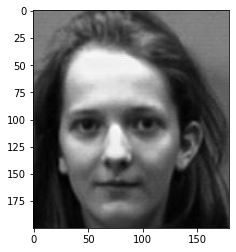

for person at index 2


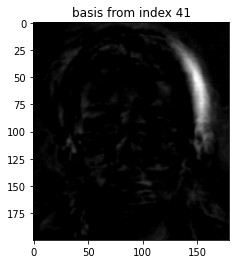

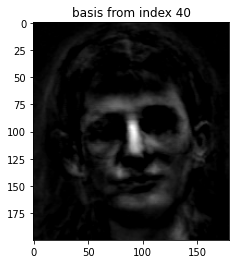

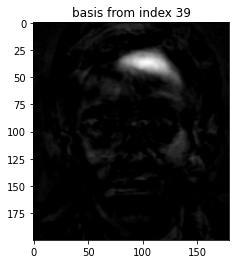

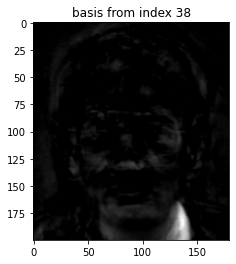

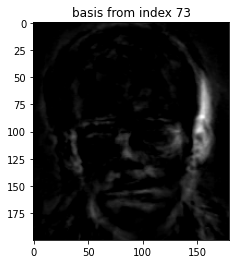

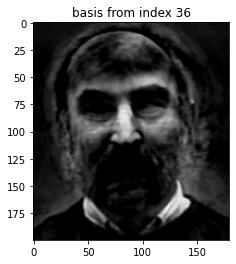

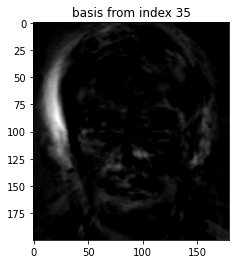

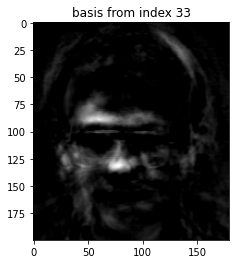

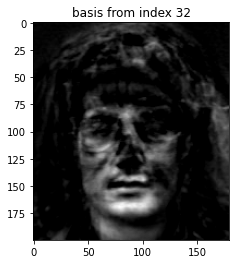

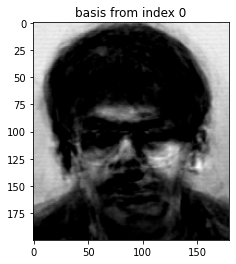

for person at index 12


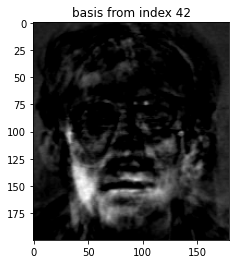

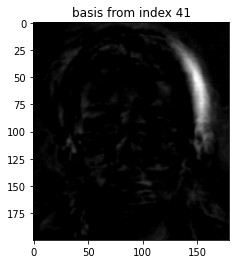

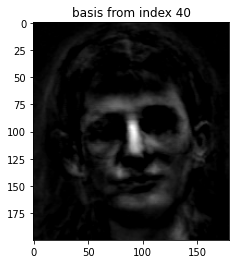

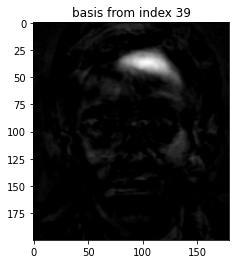

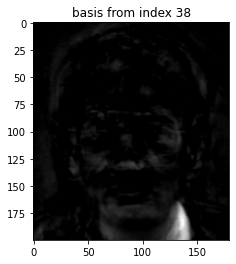

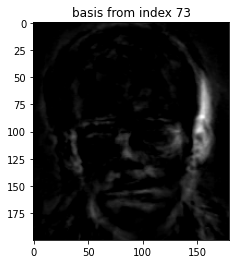

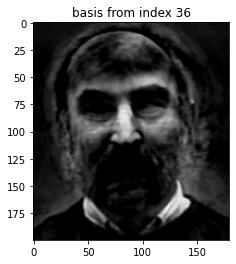

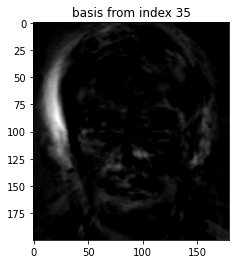

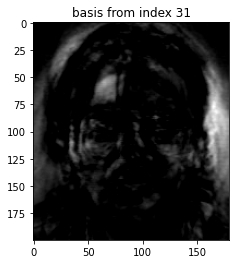

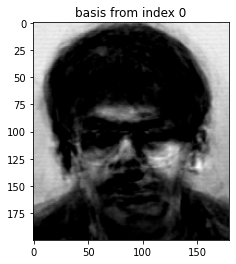

In [8]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    #search in h columns 2 and 12 for ten largest entries
    #get those entries out of W
    alph=0.5
    l1_rat=1e-05 #the optimal values that I decided
    n_comps = 75 
    faces = get_faces(path="./faces94")
    show(faces[:,1]) #second face
    plt.show()
    show(faces[:,11]) #twelfth face
    plt.show()
    
    model = NMF(n_components=n_comps,alpha_H=alph,l1_ratio=l1_rat) #the optimal goated model
    W = model.fit_transform(faces)
    H = model.components_
    
    #face 2
    face2 = H[:,1] 
    orders_2 = np.argsort(face2)[:10]
    orders_2 = orders_2[::-1] #do reverse order to get maximal
    print("for person at index 2")
    for index in orders_2:
        basis_face = W[:,index] #show the faces
        show(basis_face)
        plt.title("basis from index {}".format(index)) 
        plt.show()
    
    #face12
    face12 = H[:,11] #same process as for face 12
    orders_12 = np.argsort(face12)[:10]
    orders_12 = orders_12[::-1]
    top_ten_12 = W[orders_12]
    print("for person at index 12")
    for index in orders_12:
        basis_face = W[:,index]
        show(basis_face)
        plt.title("basis from index {}".format(index))
        plt.show()
prob5()

The person at index 1 has a very prominent eyebrow line, which is common with the top 10 most similar faces. 
The person at index 11 has a very prominent forehead and so do all the people with the top 10 most similar faces.